# Entendendo o que é um parâmetro

In [1]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [2]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [3]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


In [4]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


In [5]:
# gerando dados aleatórios de modelo de carro para simulação de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [28]:
def imprime_resultados(results):
    media = results['test_score'].mean() * 100
    desvio = results['test_score'].std() * 100
    print("Accuracy médio %.2f" % media)
    print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))
    

In [7]:
# GroupKFold em um pipeline com StandardScaler e SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

NameError: name 'GroupKFold' is not defined

In [8]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=10)

results = cross_validate(modelo, 
                         x_azar, 
                         y_azar, 
                         cv = cv, 
                         groups = dados.modelo, 
                         return_train_score=False)

imprime_resultados(results)

Accuracy médio 77.19
Intervalo [75.26, 79.13]


In [ ]:
!pip install graphviz

In [ ]:
!pip install pydot

In [9]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, 
                           out_file=None, 
                           filled=True, 
                           rounded=True, 
                           class_names=['não', 'sim'], 
                           feature_names=features)


# Quanto mais complexa a árvore, melhor?

## Explorando hiper parâmetros em 1D

In [10]:
from sklearn.model_selection import GroupKFold

def roda_arvore_de_decisao(max_depth):
    
    SEED = 301
    np.random.seed(SEED)
    
    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth)

    results = cross_validate(modelo, 
                             x_azar, 
                             y_azar, 
                             cv = cv, 
                             groups = dados.modelo, 
                             return_train_score=True)
    test_score = results['test_score'].mean()*100
    train_score = results['train_score'].mean()*100

    #print(f"Arvore max_depth = {max_depth}, treino = {train_score}, média = {test_score}")
    
    tabela = [max_depth, train_score, test_score]
    
    return tabela
    

In [11]:
resultados = [roda_arvore_de_decisao(i) for i in range(1, 33)]

In [12]:
resultados = pd.DataFrame(resultados, columns = ['max_depth', 'train', 'test'])

In [13]:
resultados.head()

,max_depth,train,test
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912


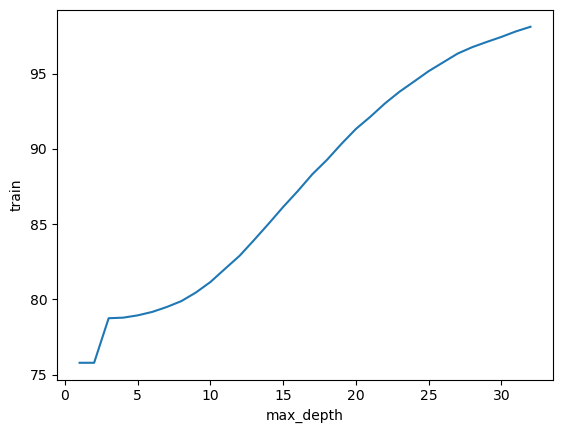

In [14]:
import seaborn as sns

sns.lineplot(x = 'max_depth', y = 'train', data=resultados);

# OverFit dos dados

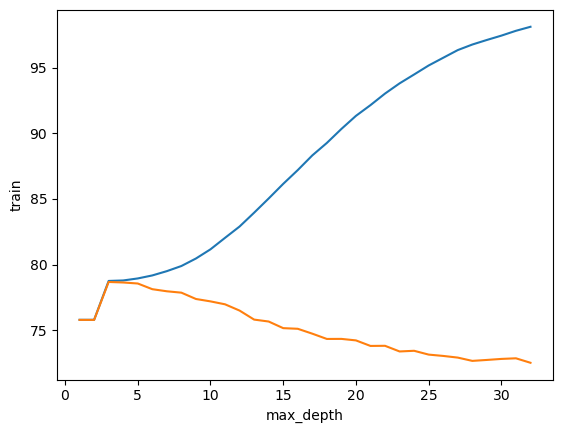

In [15]:
sns.lineplot(x = 'max_depth', y = 'train', data=resultados);
sns.lineplot(x = 'max_depth', y = 'test', data=resultados);

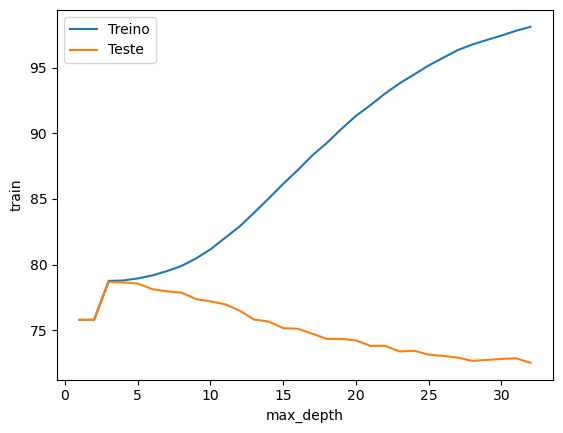

In [16]:
import matplotlib.pyplot as plt

sns.lineplot(x = 'max_depth', y = 'train', data=resultados);
sns.lineplot(x = 'max_depth', y = 'test', data=resultados);
plt.legend(["Treino", "Teste"]);

In [17]:
resultados.sort_values("test", ascending=False).head(10)

,max_depth,train,test
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185
7,8,79.887810,77.857951
8,9,80.459009,77.376956
9,10,81.158994,77.194204
10,11,82.032490,76.971552
11,12,82.894797,76.494399


## Explorando hiper parâmetros em 2D

In [18]:
from sklearn.model_selection import GroupKFold

def roda_arvore_de_decisao(max_depth, min_samples_leaf):
    
    SEED = 301
    np.random.seed(SEED)
    
    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth,
                                   min_samples_leaf=min_samples_leaf)
    results = cross_validate(modelo, 
                             x_azar, 
                             y_azar, 
                             cv = cv, 
                             groups = dados.modelo, 
                             return_train_score=True)
    test_score = results['test_score'].mean()*100
    train_score = results['train_score'].mean()*100
    tabela = [max_depth, min_samples_leaf, train_score, test_score]
    
    return tabela
    

In [19]:
resultados = []
for max_depth in range(1, 33):
    for min_samples_leaf in range(1, 33):
        tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
        resultados.append(tabela)

KeyboardInterrupt: 

In [ ]:
resultados = pd.DataFrame(resultados, columns = ['max_depth', 'min_samples_leaf', 'train', 'test'])

In [ ]:
resultados.sort_values('test', ascending=False).head()

In [ ]:
corr = resultados.corr()
corr

* Dada a **correlação** de dois valores, significa que quanto mais um valor cresce, outro cresce também. Ou seja, se isso acontece, significa que ambos são mais relacionados.

In [ ]:
sns.heatmap(corr);

In [ ]:
from pandas.plotting import scatter_matrix

scatter_matrix(resultados, figsize = (14, 8), alpha=0.3);

In [ ]:
sns.pairplot(resultados);

In [ ]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Explorando 3 ou mais parâmetros

In [ ]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100

    tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score]
    return tabela

def busca():
    resultados = []
    for max_depth in range(1,33):
        for min_samples_leaf in [32, 64, 128, 256]:
            for min_samples_split in [32, 64, 128, 256]:
                tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
                resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf", "min_samples_split", "train","test"])
    return resultados

resultados = busca()
resultados.head()

In [ ]:
corr = resultados.corr()
corr

In [ ]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
resultados.sort_values("test", ascending=False).head()

In [ ]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100
    fit_time = results['fit_time'].mean()
    score_time = results['score_time'].mean()
    tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
    return tabela

def busca():
    resultados = []
    for max_depth in range(1,33):
        for min_samples_leaf in [32, 64, 128, 256]:
            for min_samples_split in [32, 64, 128, 256]:
                tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
                resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf", "min_samples_split", "train","test", "fit_time", "score_time"])
    return resultados

resultados = busca()
resultados.head()

In [ ]:
corr = resultados.corr()
corr

In [ ]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
resultados.sort_values("test", ascending=False).head()

# Explorando espaços de hiper parâmetros com GridSearchCV

In [32]:
from sklearn.model_selection import GridSearchCV

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {"max_depth" : [3, 5],
                        "min_samples_split": [32, 64, 128],
                        "min_samples_leaf": [32, 64, 128],
                        "criterion": ["gini", "entropy"] 
                       }

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = GroupKFold(n_splits = 10))

busca.fit(x_azar, y_azar,groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008792,0.001897,0.001201,0.000599,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.005730,0.007059,0.001969,0.004599,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.006535,0.007346,0.001565,0.004694,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.007670,0.005556,0.001323,0.002362,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.007422,0.003515,0.000933,0.002114,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [33]:
print(busca.best_params_)
print(busca.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67263337284332


In [34]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

In [35]:
from sklearn.metrics import accuracy_score 

predicoes = melhor.predict(x_azar) 
accuracy = accuracy_score(predicoes, y_azar) * 100

print("Accuracy para os dados foi %.2f%%" % accuracy)

Accuracy para os dados foi 78.75%


## Nested cross validation e validando o melhor modelo

* No caso de **Cross Validation** com busca de hiper parâmetros, fazemos uma nova validação cruzada. Chama-se **nested cross validation**.

In [36]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = GroupKFold(n_splits=10), groups = dados.modelo)

C:\Users\TTMENDES\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\TTMENDES\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\TTMENDES\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 891, in fit
    self._run_search(evaluate_candidates)
  File "C:\Users\TTMENDES\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 1392, in _run_search
    evaluate_candidates(ParameterGrid

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
import numpy as np


SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
                        "max_depth" : [3, 5],
                        "min_samples_split": [32, 64, 128],
                        "min_samples_leaf": [32, 64, 128],
                        "criterion": ["gini", "entropy"]
                        }

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009247,0.001572,0.002137,0.000170,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.006801,0.000747,0.001014,0.000017,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.003834,0.003159,0.003870,0.006037,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.006630,0.003271,0.001006,0.000645,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.007287,0.001750,0.000200,0.000399,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


In [38]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
scores

array([0.7895, 0.7825, 0.7905, 0.7715, 0.7995])

In [39]:
def imprime_score(scores):
    media = scores.mean() * 100
    desvio = scores.std() * 100
    print("Accuracy médio %.2f" % media)
    print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))
    

In [40]:
from sklearn.tree import export_graphviz
import graphviz


features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names=features)


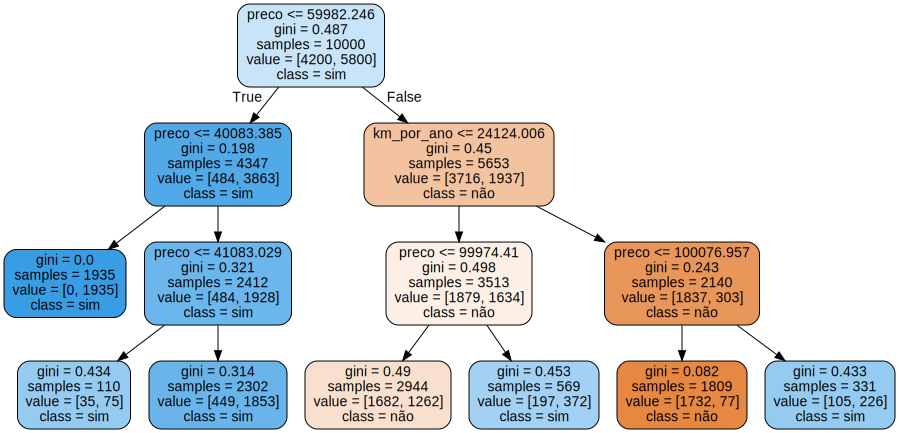

In [43]:
features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names=features)

graph = graphviz.Source(dot_data)
graph

# Explorando aleatoriamente

In [20]:
from sklearn.model_selection import GridSearchCV, KFold

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009747,0.001851,0.002106,0.000556,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.008476,0.000775,0.001756,0.000632,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.008000,0.000008,0.001205,0.000399,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.006000,0.003033,0.000798,0.000747,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.009691,0.004404,0.001211,0.000395,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


In [21]:
from sklearn.model_selection import RandomizedSearchCV

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros, 
                    n_iter = 16,
                    cv = KFold(n_splits = 5),
                          random_state = SEED)


busca.fit(x_azar, y_azar,groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011202,0.001152,0.002053,0.000550,128,128,5,gini,"{'min_samples_split': 128, 'min_samples_leaf':...",0.4330,0.4525,0.771,0.742,0.7725,0.6342,0.156817,1
1,0.007014,0.000127,0.000954,0.000095,64,32,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.4015,0.4165,0.771,0.766,0.7725,0.6255,0.176848,11
2,0.006598,0.000489,0.001293,0.000396,64,128,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.4015,0.4165,0.771,0.766,0.7725,0.6255,0.176848,11
3,0.012240,0.000737,0.000955,0.000091,32,64,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.4240,0.4535,0.771,0.750,0.7445,0.6286,0.155544,5
4,0.012819,0.000965,0.001185,0.000409,64,64,5,entropy,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.4240,0.4535,0.771,0.750,0.7445,0.6286,0.155544,5


In [22]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
scores

array([0.7755, 0.78  , 0.8055, 0.7855, 0.774 ])

In [29]:
def imprime_score(scores):
    media = scores.mean() * 100
    desvio = scores.std() * 100
    print("Accuracy médio %.2f" % media)
    print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))
    

In [30]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(scores)

Accuracy médio 78.22
Intervalo [75.79, 80.65]


In [41]:
features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                        class_names=["não", "sim"],
                        feature_names = features)


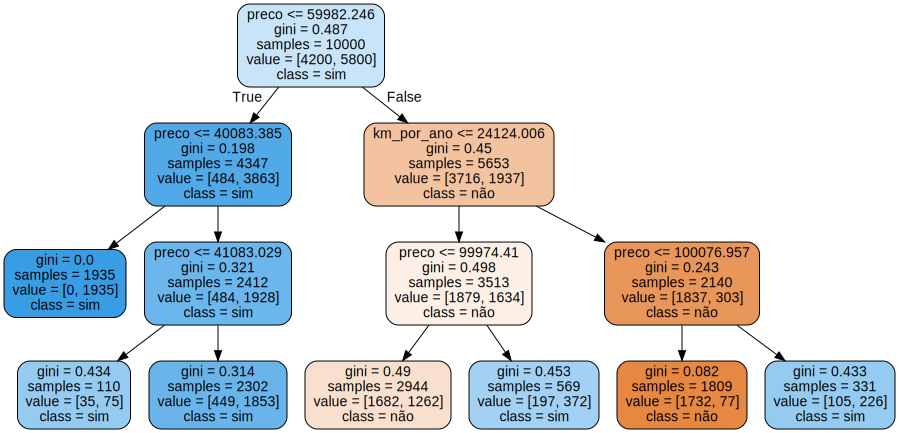

In [42]:
features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                        class_names=["não", "sim"],
                        feature_names = features)

graph = graphviz.Source(dot_data)
graph

# Espaços maiores e sampling menores

In [44]:
from scipy.stats import randint

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5, 10, 15, 20, 30, None],
    "min_samples_split" : randint(32, 128),
    "min_samples_leaf" : randint(32, 128),
    "criterion" : ["gini", "entropy"]

}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros, 
                    n_iter = 16,
                    cv = KFold(n_splits = 5, shuffle=True),
                          random_state = SEED)


busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010530,0.000449,0.001069,0.000144,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7840,0.7760,0.8025,0.7930,0.7795,0.7870,0.009618,1
1,0.014300,0.001731,0.001299,0.000395,gini,15,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7740,0.7725,0.7830,0.7805,0.7725,0.7765,0.004393,14
2,0.012198,0.000746,0.001216,0.000393,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7705,0.7745,0.7990,0.7790,0.7735,0.7793,0.010221,8
3,0.014985,0.000633,0.001063,0.000125,gini,None,46,62,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7575,0.7730,0.7725,0.7835,0.7560,0.7685,0.010378,16
4,0.011800,0.000400,0.001607,0.000496,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7705,0.7735,0.7995,0.7790,0.7745,0.7794,0.010413,7


In [45]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(scores)
melhor = busca.best_estimator_
print(melhor)

Accuracy médio 78.71
Intervalo [77.49, 79.93]
DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=71,
                       min_samples_split=100)


# Será que vale a pena explorar mais?

In [49]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
resultados_ordenados_pela_media.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010530,0.000449,0.001069,0.000144,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7840,0.7760,0.8025,0.7930,0.7795,0.7870,0.009618,1
6,0.012052,0.000110,0.001349,0.000543,entropy,5,73,72,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.7840,0.7690,0.8005,0.7930,0.7730,0.7839,0.011825,2
12,0.009793,0.000397,0.001202,0.000400,gini,5,64,67,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.7840,0.7690,0.8005,0.7930,0.7730,0.7839,0.011825,2
8,0.012398,0.001018,0.001202,0.000400,gini,10,108,110,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.7760,0.7740,0.7970,0.7815,0.7765,0.7810,0.008373,4
13,0.012241,0.000749,0.001623,0.000509,gini,10,125,59,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.7745,0.7745,0.7995,0.7790,0.7745,0.7804,0.009708,5


In [52]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media.iterrows():
    print("%.3f +- (%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.787 +- (0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
0.784 +- (0.024) {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 73, 'min_samples_split': 72}
0.784 +- (0.024) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
0.781 +- (0.017) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 108, 'min_samples_split': 110}
0.780 +- (0.019) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 125, 'min_samples_split': 59}
0.780 +- (0.012) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 103, 'min_samples_split': 96}
0.779 +- (0.021) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 126, 'min_samples_split': 84}
0.779 +- (0.020) {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 124, 'min_samples_split': 88}
0.779 +- (0.009) {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 101, 'min_samples_split': 52}
0.779 +- (0.014) {'criterion': 'entropy', 

In [53]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(scores)
melhor = busca.best_estimator_
print(melhor)

Accuracy médio 78.70
Intervalo [76.85, 80.55]
DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=71,
                       min_samples_split=100)


# Testando um GridSearch mais longo

In [54]:
from sklearn.ensemble import RandomForestClassifier
import time 

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : [10, 100],
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "bootstrap" : [True, False],
    "criterion": ["gini", "entropy"]

}

tic = time.time()
busca = GridSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)



resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 161.65 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.028194,0.003951,0.003197,0.000392,True,gini,3,32,32,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7560,0.7490,0.7850,0.7450,0.7619,0.015357,130
1,0.262906,0.013301,0.019406,0.001493,True,gini,3,32,32,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7655,0.7555,0.7945,0.7850,0.7625,0.7726,0.014685,93
2,0.028136,0.000862,0.004127,0.000683,True,gini,3,32,64,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7780,0.7635,0.7835,0.7845,0.7560,0.7731,0.011373,89
3,0.265885,0.007903,0.017670,0.002809,True,gini,3,32,64,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7425,0.7550,0.7950,0.7850,0.7620,0.7679,0.019356,119
4,0.027215,0.000981,0.003185,0.000410,True,gini,3,32,128,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7755,0.7405,0.7485,0.7760,0.7630,0.7607,0.014250,135


In [55]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
    print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.780 +-(0.020) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.020) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 128, 'n_estimators': 10}
0.778 +-(0.030) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.027) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.033) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 100}


# Comparando com o RandomizedSearch

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import time 

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : [10, 100],
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "bootstrap" : [True, False],
    "criterion": ["gini", "entropy"]

}

tic = time.time()
busca = GridSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)



resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

In [ ]:
tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter = 20,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)

In [ ]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
    print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

In [ ]:
tic = time.time()
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)

imprime_score(scores)
melhor = busca.best_estimator_
print(melhor)

In [56]:
SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : randint(10, 101),
    "max_depth" : randint(3, 6),
    "min_samples_split": randint(32, 129),
    "min_samples_leaf": randint(32, 129),
    "bootstrap" : [True, False],
    "criterion": ["gini", "entropy"]

}

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter = 80,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)



resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 82.27 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.268860,0.011978,0.017606,0.001700,False,gini,3,50,93,89,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7715,0.7620,0.7750,0.7855,0.7580,0.7704,0.009744,75
1,0.216054,0.007668,0.016600,0.001178,True,gini,3,88,104,80,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7715,0.7575,0.7925,0.7855,0.7575,0.7729,0.014277,63
2,0.222783,0.012628,0.017147,0.001910,True,gini,3,126,84,77,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7685,0.7695,0.7925,0.7795,0.7575,0.7735,0.011781,59
3,0.138461,0.005288,0.011275,0.000718,True,gini,3,57,73,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7720,0.7670,0.7830,0.7865,0.7580,0.7733,0.010429,60
4,0.226625,0.023707,0.015684,0.000739,True,gini,4,52,88,68,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7720,0.7685,0.7930,0.7850,0.7585,0.7754,0.012220,30


In [ ]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
    print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

# Treino teste validação, otimização sem validação cruzada

In [57]:
from sklearn.model_selection import train_test_split

SEED=301
np.random.seed(SEED)

x_treino_teste, x_validacao, y_treino_teste, y_validacao = train_test_split(x_azar, y_azar, test_size=0.2, shuffle=True, stratify=y_azar)

print(x_treino_teste.shape)
print(x_validacao.shape)
print(y_treino_teste.shape)
print(y_validacao.shape)

(8000, 3)
(2000, 3)
(8000,)
(2000,)


In [59]:
from sklearn.model_selection import StratifiedShuffleSplit

espaco_de_parametros = {
    "n_estimators" : randint(10, 101),
    "max_depth" : randint(3, 6),
    "min_samples_split": randint(32, 129),
    "min_samples_leaf": randint(32, 129),
    "bootstrap" : [True, False],
    "criterion": ["gini", "entropy"]

}

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.25)

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter = 5,
                    cv = split)
busca.fit(x_treino_teste, y_treino_teste)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)



resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 0.85 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.091998,0.0,0.007000,0.0,True,gini,5,89,58,24,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7885,0.7885,0.0,3
1,0.083996,0.0,0.007001,0.0,False,entropy,3,71,55,27,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7920,0.7920,0.0,1
2,0.052577,0.0,0.006001,0.0,True,entropy,3,33,99,21,"{'bootstrap': True, 'criterion': 'entropy', 'm...",0.7910,0.7910,0.0,2
3,0.174326,0.0,0.014000,0.0,True,gini,3,98,100,67,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7785,0.7785,0.0,5
4,0.251117,0.0,0.014999,0.0,False,entropy,4,88,64,63,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7885,0.7885,0.0,3


In [60]:
tic = time.time()
scores = cross_val_score(busca, x_validacao, y_validacao, cv = split)
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)

scores

Tempo 0.54 segundos


array([0.732])